In [32]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import sqlite3
from scipy.optimize import curve_fit
from matplotlib.backends import backend_pdf

In [33]:
# SUPPORT FUNCTIONS TO CONVERT CHANNEL ID TO BOARD/PMT ID
# using hardware database inside icarus_data

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_62_00/icarus_data/database/ChannelMapICARUS.db", table="pmt_placements"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)

    con.close()

    return df

def get_channel_id(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    # print(board, ",", digitizer_channel, "-->", ch.values[0][0])

    return ch.values[0][0]

def get_PMT_id(db, channels):
     
    if np.isscalar(channels):
        pmt_id = db[db.channel_id==channels].pmt_id.values[0]
        return pmt_id
    else:
        pmt_ids = [ db[db.channel_id==ch].pmt_id.values[0] for ch in channels ] 
        return pmt_ids
    
def get_channel_board(db, ch):
    
    board = db.loc[db['channel_id']==ch].digitizer_label.values[0]
    return board

In [34]:
# load data from all files for calibrations
# returns dict: DC offset vs dataframes with data

def loadfiles(rundb, basepath="../"):
    
    data = {}
    for offset, run in rundb.items():
        file = basepath + run + "/measChannelBaselines_run" + run + ".csv"
        df = pd.read_csv(file, sep=',')
        data[offset] = df
    return data

In [35]:
# checks if baselines is stable at the beginning of each run, for each channel, within expected fluctuations
# necessary to make sure it is okay to use the mean computed on the first events
# n: number of events
# eps: acceptable fluctuations

def check_baseline_stability(geodb, rundb, data, n=20, eps=10):
    
    issues = {}
    
    # for each run
    for offset, run in rundb.items():
    
        timestamps = data[offset]["timestamp"].to_numpy()
        time = [datetime.fromtimestamp(t).strftime('%H:%M') for t in timestamps]
        fig = plt.figure()
        c = []
        
        #for each channel
        for ch in range(360):
            
            col = "baseline_ch" + str(ch)
            label_name = "Ch " + str(ch)
            baselines = data[offset][col].head(n).to_numpy()
            
            #check fluctuations
            if np.std(baselines) > eps:
                print("Warning: Run " + run + ", Ch " + str(ch) + ", board " + get_channel_board(geodb,ch) + ": instable baseline!")
                plt.plot(time,data[offset][col],label=label_name)
                c.append(ch)
        
        if fig.get_axes():
            plt.title(run)
            plt.xlabel("Time")
            plt.ylabel("Baseline [ADC]")
            plt.setp(plt.gca().get_xticklabels(), rotation=60, ha="right")
            plt.tight_layout()
            plt.grid()
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
            issues[offset] = c
            
    return issues

In [36]:
# checks stability of using the median to compute the baseline at start
# only for channels that have shown to be instable!
# n: number of events

def check_median_stability(issues, rundb, data, n=20):
    
    for offset in issues.keys():
        
        run = rundb[offset]
        channels = issues[offset]
        print("Run " + run + ", pedestal " + str(offset) + ": " + str(len(channels)) + " channels")
        fig = plt.figure(figsize=(18,40))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        i = 0
        for ch in channels:
            
            col = "baseline_ch" + str(ch)
            baselines = data[offset][col].head(n).to_numpy()
            median = np.median(baselines)
            i = i+1
            ax = plt.subplot(len(channels),4,i)
            ax.hist(baselines, bins=50, range=(np.amin(baselines)-10,np.amax(baselines)+10), histtype='bar', lw=2, label="Mean: {:.1f}\nStd: {:.1f}".format(np.mean(baselines),np.std(baselines)))
            ax.axvline(x=median, color="red", linestyle='dotted')
            ax.legend()
            ax.set_title(col)
        
        #fig.supxlabel("Baseline [ADC]",fontsize=16)
        plt.show()

In [37]:
def get_channel_data(ch, data, n=20):
    
    bs = []
    err = []
    col = "baseline_ch" + str(ch)
    for offset, df in data.items():
        baselines = df[col].head(n).to_numpy()
        bs.append(np.median(baselines))
        rms = np.sqrt( np.square(np.subtract(baselines,np.median(baselines))).mean())
        if rms < 1.0: rms = 1.0
        err.append(rms)
    
    return list(data.keys()), bs, err

def line(x,a,b):
    return a*x+b

In [38]:
def extrapolate_line(bs_target, a, err_a, b, err_b):
    
    dacnom = (bs_target-b)/a
    
    dxdb = -1./a
    dxda = (b-bs_target)/(a**2)
    
    edacnom = np.sqrt( (dxdb*err_b)**2 + (dxda*err_a)**2 )
    
    return dacnom, edacnom

In [39]:
def dofit( dcoffset, baseline, error_baseline, bs_target = 14747):
    
    a0 = (baseline[1]-baseline[0])/(dcoffset[1]-dcoffset[0])
    b0 = baseline[0]
    
    params, pcov = curve_fit(line, dcoffset, baseline, sigma=error_baseline, absolute_sigma=True, p0=(a0,b0))
            
    stderr = np.sqrt(np.diag(pcov))
    
    xint = np.linspace( np.min(dcoffset)-10, np.max(dcoffset)+10, 1000 )
    yint = line(xint, params[0], params[1])
    
    dacnom, edacnom= extrapolate_line( bs_target, params[0], stderr[0] , params[1], stderr[1] )
    
    return params, stderr, xint, yint, dacnom, edacnom

## Baseline calibration

Several runs at different DC offset values of the DAC, using the configuration with `CalibOnConfig = false`, `LockTempCalibration = true` and `AdcCalibration = false`

In [40]:
rundb = { 0:"9483", 3277:"9484", 6554:"9451", 9831:"9485", 13108:"9468", 32767:"9471"}
geodb = readSqlitedb()   

data = loadfiles(rundb, basepath="../")

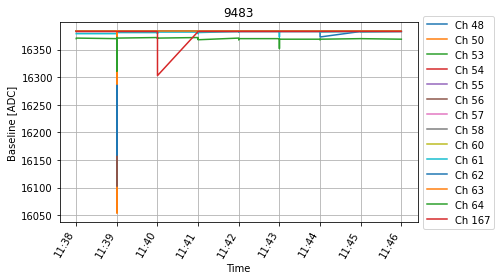

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [41]:
issues = check_baseline_stability(geodb, rundb, data, n=20)
#print(issues.items())

Run 9483, pedestal 0: 14 channels


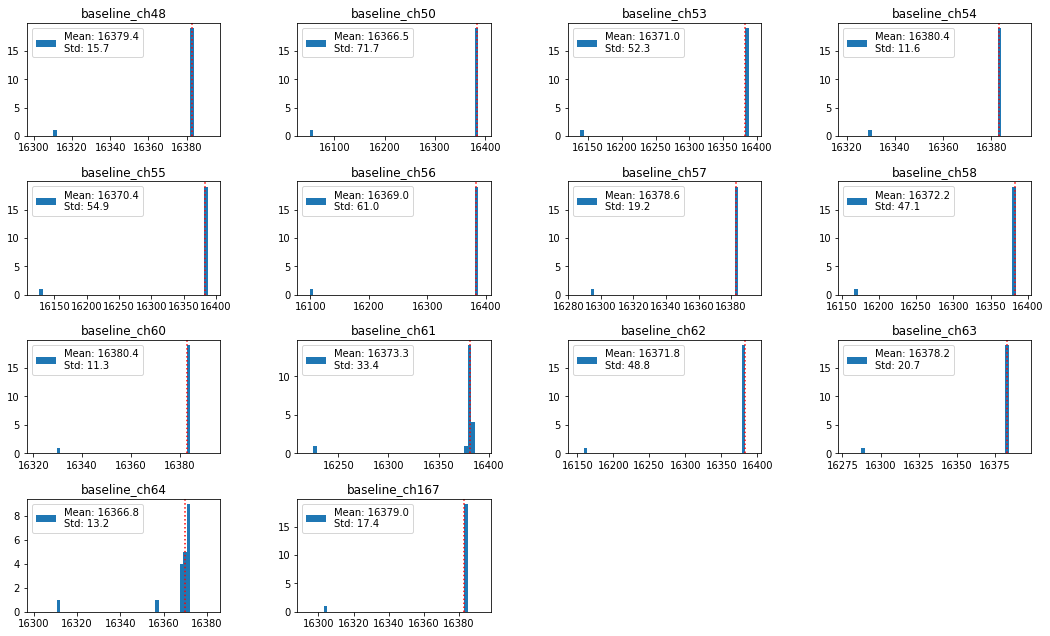

In [42]:
check_median_stability(issues, rundb, data, n=20)

### Plot one channel

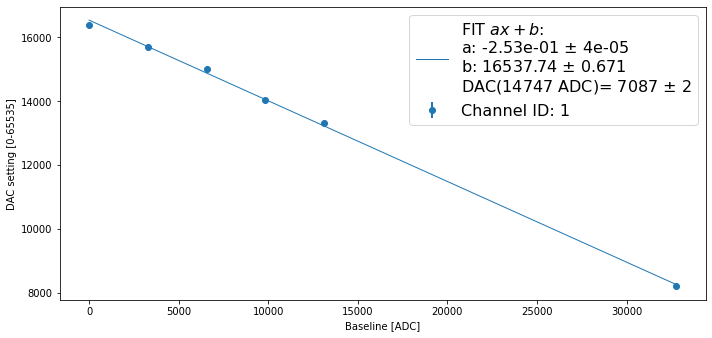

In [43]:
channel_id = 1
dac, bs, err = get_channel_data(channel_id, data, n=20)
target = 14747

fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}
    
out=plt.errorbar( x=dac, y=bs, yerr=err, label=("Channel ID: %d" % channel_id), **kargs)
p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, err, bs_target=target)
            
label= "FIT $ax + b$: \n"
label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
plt.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
plt.ylabel("DAC setting [0-65535]")
plt.xlabel("Baseline [ADC]")
plt.legend(fontsize=16)
    
fig.tight_layout()

### Plot everything

In [44]:
pdf = backend_pdf.PdfPages("calibrations/baseline_calibration_16Feb2023.pdf")
target = 14747

calibration = []
DAC_nominal = []

for channel_id in range(0, 360):
            
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8))
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    dac, bs, ebs = get_channel_data(channel_id, data, n=20)
             
    out=ax.errorbar( x=dac, y=bs, yerr=ebs, label=("Channel ID: %d" % channel_id), **kargs )
    
    p, ep, xint, yint, dacnom, edacnom = dofit(dac, bs, ebs, bs_target=target)
   
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(dacnom)

    label= "FIT $ax + b$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
    ax.set_ylabel("DAC setting [0-65535]")
    ax.set_xlabel("Baseline [ADC]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    pdf.savefig( fig )
    
    plt.close()


pdf.close()

In [45]:
calibDB = pd.DataFrame(calibration)
calibDB.to_csv("calibrations/baseline_calibration_16Feb2023.csv",sep=',')

## Produce output files

### Write requested DC offset

In [48]:
print("Writing DC offsets to equalize baselines at " + str(target))

path = "calibrations/DC_offsets_for_"+str(target)+".csv"
ofile = open(path,"w")
header = "channel_id,baseline,DC_offset\n"
ofile.write(header)

for channel_id in range(0,360):
    out = str(channel_id) + "," + str(target) + ","
    out += str(int(DAC_nominal[channel_id]))+"\n"
    ofile.write(out)
    
ofile.close()

Writing DC offsets to equalize baselines at 14747


In [49]:
current = 6554
print("Writing baselines corresponding to " + str(current))

path = "calibrations/baselines_at_"+str(current)+".csv"
ofile = open(path,"w")
header = "channel_id,baseline\n"
ofile.write(header)

for channel_id in range(0,360):
    
    a = calibDB[calibDB.channel_id==channel_id].p0.values[0]
    b = calibDB[calibDB.channel_id==channel_id].p1.values[0]
    bs = line(current,a,b)
    
    out = str(channel_id) + "," + str(int(bs))+"\n"
    ofile.write(out)
    
ofile.close()

Writing baselines corresponding to 6554
